This notebook conducts an Exploratory Data Analysis (EDA) on the standardized version of the variable `count` which is, as the name implies, a count and not continuous variable. Therefore, the methods of the other continuous variables' EDA would not be approrpriate without special investigation.

## Import packages:

In [1]:
import gresearch_crypto

from datetime import datetime
import gc
import matplotlib.pyplot as plt
import matplotlib.dates as md
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

## Declare variables

In [2]:
train_filepath = '/kaggle/input/g-research-crypto-forecasting/train.csv'
asset_details_filepath = '/kaggle/input/g-research-crypto-forecasting/asset_details.csv'

## Declare Cleaning Functions

In [3]:
def clean_dates(df):
    '''
    Function to clean timestamps of an individual coin 
    by the earliest and latest timestamps observed for that coin.
    Also fills in missing values by the method chosen for the interpolate function.
    
    Inputs: 
        df (pd.DataFrame.GroupBy object) :
            Grouped Dataframe by unique coins. All timestamps must be
            in intervals of 60 seconds.

    Outputs:
        constant_dates_df (pd.DataFrame) :
            Dataframe with timestamps and filled missing values.
    '''
    
    df = df.copy()
    
    dates = range(min(df["timestamp"]), max(df["timestamp"]), 60)
    
    df.set_index("timestamp", inplace = True)
    
    df = df.reindex(dates)
    
    # replace the 9 infinite values with NaN, which are interpolated in the next line
    df.replace([np.inf, -np.inf], np.nan, inplace = True)
    
    # don't fill missing values at end of dataset, where they do not
    # have ending observations to interpolate with
    df.interpolate(method = "linear", inplace = True, limit_area = "inside")
    
    return df
    
def standardize_data(df):
    '''
    Function to standardize data by creating rows for every timestamp
    and subsetting to only consider when all coins had their first observation made.
    
    Inputs:
        df (pd.DataFrame) :
            Time series data to be standardized
            
    Outputs:
        standard_df (pd.DataFrame) :
            Time series data now standardized
    '''
    
    # deep copy to not alter the original
    df = df.copy()
    
    # fill missing rows / values between coin's start and stop date
    # Note: Missing rows beyond an individual coin's start / stop date are not created,
    # only those between are filled in
    standard_df = df.groupby("Asset_ID").apply(clean_dates).reset_index(level = 0, drop = True)
    
    # reset twice so timestamp is only a column and not also index, 
    # this makes each entry have a unique index
    standard_df = standard_df.reset_index()
    
    # get the earliest timestamp for each coin, then get the latest timestamp out of those.
    # this shows when the latest coin was introduced, after which there are observations for
    # all coins
    first_timestamp = max(standard_df.groupby("Asset_ID")["timestamp"].min())
    
    # subset to only consider the time period where observations existed for all coins
    standard_df = standard_df.loc[standard_df["timestamp"] >= first_timestamp]
    
    # drop ending rows with missing values
    standard_df.dropna(inplace = True)
    
    # convert to int to better reflect nature of data
    standard_df["Count"] = standard_df["Count"].astype("int")
    
    return standard_df

## Import and Clean Data

In [4]:
df = pd.read_csv(train_filepath)
asset_details_df = pd.read_csv(asset_details_filepath)

standard_df = standardize_data(df)

In [5]:
df

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.580000,2399.500000,2357.140000,2374.590000,1.923301e+01,2373.116392,-0.004218
1,1514764860,0,5.0,8.530000,8.530000,8.530000,8.530000,7.838000e+01,8.530000,-0.014399
2,1514764860,1,229.0,13835.194000,14013.800000,13666.110000,13850.176000,3.155006e+01,13827.062093,-0.014643
3,1514764860,5,32.0,7.659600,7.659600,7.656700,7.657600,6.626713e+03,7.657713,-0.013922
4,1514764860,7,5.0,25.920000,25.920000,25.874000,25.877000,1.210873e+02,25.891363,-0.008264
...,...,...,...,...,...,...,...,...,...,...
24236801,1632182400,9,775.0,157.181571,157.250000,156.700000,156.943857,4.663725e+03,156.994319,NaN
24236802,1632182400,10,34.0,2437.065067,2438.000000,2430.226900,2432.907467,3.975460e+00,2434.818747,NaN
24236803,1632182400,13,380.0,0.091390,0.091527,0.091260,0.091349,2.193732e+06,0.091388,NaN
24236804,1632182400,12,177.0,0.282168,0.282438,0.281842,0.282051,1.828508e+05,0.282134,NaN


In [6]:
standard_df

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
671913,1555079640,0.0,13,17.840000,17.843600,17.840000,17.840100,9.212400e+02,17.841473,-0.001787
671914,1555079700,0.0,12,17.840000,17.856500,17.840000,17.847100,1.270400e+02,17.846861,-0.001602
671915,1555079760,0.0,22,17.856500,17.860000,17.850400,17.850400,1.261230e+03,17.857771,-0.000504
671916,1555079820,0.0,5,17.859400,17.859500,17.845600,17.859500,2.382000e+01,17.848033,0.000566
671917,1555079880,0.0,4,17.853200,17.858300,17.849900,17.849900,3.577000e+02,17.850593,0.000000
...,...,...,...,...,...,...,...,...,...,...
26080009,1632181200,13.0,986,0.090885,0.091054,0.090710,0.090941,5.734456e+06,0.090831,0.000199
26080010,1632181260,13.0,715,0.091010,0.091277,0.090980,0.091203,1.989048e+06,0.091125,-0.003477
26080011,1632181320,13.0,527,0.091171,0.091295,0.091092,0.091180,2.386078e+06,0.091185,-0.002437
26080012,1632181380,13.0,463,0.091206,0.091290,0.091028,0.091081,1.568854e+06,0.091131,0.004843


In [7]:
asset_details_df

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


## Stationarity EDA

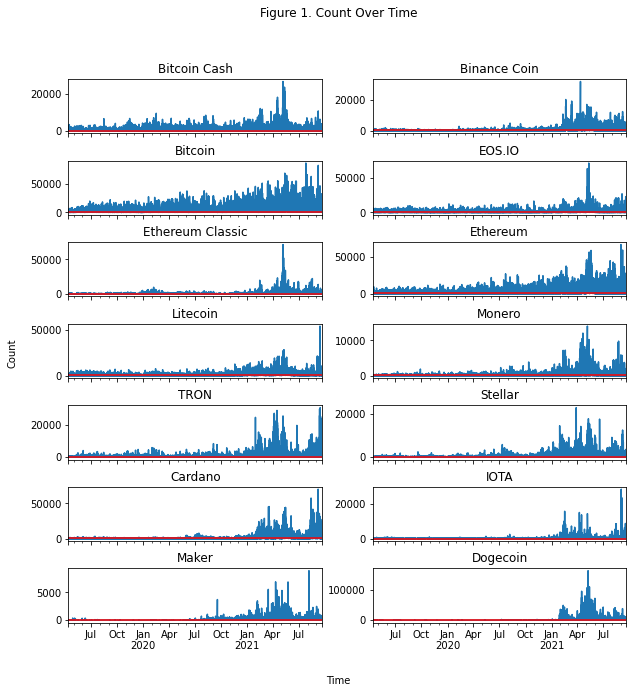

In [8]:
standard_df.loc[:, "datetime"] = pd.to_datetime(standard_df.loc[:, "timestamp"].values, 
                                                unit = "s", infer_datetime_format = True)

fig, axes = plt.subplots(nrows = int(len(asset_details_df)/2), ncols = 2, 
                         sharex = True, figsize = (10,10))
axes = axes.flatten()

for ax, asset in zip(axes, asset_details_df["Asset_ID"]):
    standard_df.loc[standard_df["Asset_ID"] == asset].plot(x = "datetime",
        y = "Count", ax = ax, legend = False, xlabel = "", ylabel = "",
        title = asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    ax.axhline(y = round(int(standard_df.loc[standard_df["Asset_ID"] == asset, "Count"].mean())), 
             xmin = 0, xmax = 1, color = "r")
    
fig.suptitle("Figure 1. Count Over Time")
fig.text(0.5, 0.04, 'Time', ha='center')
fig.text(0.04, 0.5, 'Count', va='center', rotation='vertical')
fig.subplots_adjust(hspace=.5)
    
plt.show()

In [9]:
del fig
del axes
del df
gc.collect()

54

Shown above, the values of count during the course of the standardized dataset is clearly non stationary. As crypto currency became more popular, more often higher counts were traded in any given minute. This makes the variable non-stationary in the mean. In addition, the fluctuation of trades seems to increase as well, with large spikes but also large drops. This also makes the variable non-stationary in the variance as well. 

Because this is count data, likely best modeled with a form of Poisson distribution, the Gaussian tests and methods for times series are not applicable. Poisson/count versions of these tests could be used in R or developed for Python, but for simplicity stationarity will be investigated with visual inspection only.

For example, the same differencing and log operations will be applied.

In [10]:
# Note: Count in this dataset is never zero, i.e. it is always > 0
# For real data, or when filling in missing data, zeros may occur
# Therefore these should be planned for in future implementations
standard_df["count_t"] = (np.log(standard_df["Count"].copy())).diff()
standard_df.fillna(0, inplace = True)

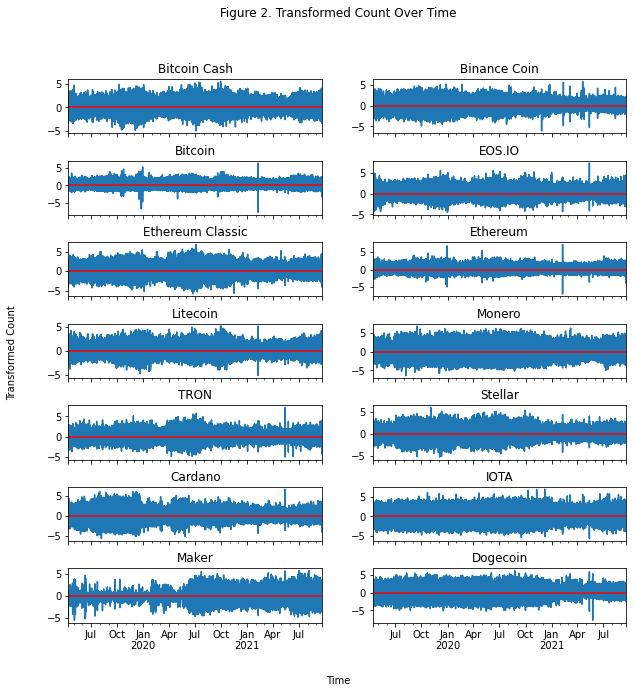

In [11]:
fig, axes = plt.subplots(nrows = int(len(asset_details_df)/2), ncols = 2, 
                         sharex = True, figsize = (10,10))
axes = axes.flatten()

for ax, asset in zip(axes, asset_details_df["Asset_ID"]):
    standard_df.loc[standard_df["Asset_ID"] == asset].plot(x = "datetime",
        y = "count_t", ax = ax, legend = False, xlabel = "", ylabel = "",
        title = asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    ax.axhline(y = round(int(standard_df.loc[standard_df["Asset_ID"] == asset, "count_t"].mean())), 
             xmin = 0, xmax = 1, color = "r")
    
fig.suptitle("Figure 2. Transformed Count Over Time")
fig.text(0.5, 0.04, 'Time', ha='center')
fig.text(0.04, 0.5, 'Transformed Count', va='center', rotation='vertical')
fig.subplots_adjust(hspace=.5)
    
plt.show()

Shown above, the same operation now makes count to appear stationary.

While count data is normally modeled with a Poisson distribution, it is important to check how well the assumptions of it are matched by the data.

In [11]:
for asset in asset_details_df["Asset_ID"]:
    
    print(asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    print("Mean: " + str(standard_df.loc[standard_df["Asset_ID"] == asset, "Count"].mean()))
    print("Variance: " + str(standard_df.loc[standard_df["Asset_ID"] == asset, "Count"].var()))
    print()

Bitcoin Cash
Mean: 202.91527791936537
Variance: 136122.4048184783

Binance Coin
Mean: 266.08473414260044
Variance: 269160.7024761889

Bitcoin
Mean: 1457.4668257030376
Variance: 3433474.5347726084

EOS.IO
Mean: 306.11002147029916
Variance: 536286.4161833918

Ethereum Classic
Mean: 176.03355716710337
Variance: 420929.05703229335

Ethereum
Mean: 921.0437899941713
Variance: 2066361.5533268966

Litecoin
Mean: 296.3885758398046
Variance: 347610.63474053727

Monero
Mean: 43.33911827808045
Variance: 14128.256020139012

TRON
Mean: 221.28682771077118
Variance: 224682.6388090262

Stellar
Mean: 157.20456432568554
Variance: 119700.0917943378

Cardano
Mean: 319.4385411713803
Variance: 667260.6549054076

IOTA
Mean: 36.83693428407564
Variance: 19427.902944475107

Maker
Mean: 27.312358495631624
Variance: 6509.249974419926

Dogecoin
Mean: 427.84004004572654
Variance: 3558666.7975114924



Shown above, for all coins the variance is much larger than the mean. This violates the Poisson distribution assumption that variance is equal to the expected value. In this case, because variance is greater, there is overdispersion.

In addition, Poisson distributions also assume that P(X = 0) = exp(-E[X]) or the probability of observing a count of zero is equal to the exponential of the negative expected value. 

In [18]:
for asset in asset_details_df["Asset_ID"]:
    
    print(asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    print("Zero Probability: " + 
          str(len(standard_df.loc[(standard_df["Asset_ID"] == asset) & (standard_df["Count"] == 0), "Count"])/
              len(standard_df.loc[standard_df["Asset_ID"] == asset, "Count"])))
    print("exp(-E[X]): " + str(np.exp(-standard_df.loc[standard_df["Asset_ID"] == asset, "Count"].mean())))
    print()

Bitcoin Cash
Zero Probability: 0.0
exp(-E[X]): 7.501232459529405e-89

Binance Coin
Zero Probability: 0.0
exp(-E[X]): 2.762703614050155e-116

Bitcoin
Zero Probability: 0.0
exp(-E[X]): 0.0

EOS.IO
Zero Probability: 0.0
exp(-E[X]): 1.1433694387193316e-133

Ethereum Classic
Zero Probability: 0.0
exp(-E[X]): 3.547385770288254e-77

Ethereum
Zero Probability: 0.0
exp(-E[X]): 0.0

Litecoin
Zero Probability: 0.0
exp(-E[X]): 1.9061560988507122e-129

Monero
Zero Probability: 0.0
exp(-E[X]): 1.532384365433695e-19

TRON
Zero Probability: 0.0
exp(-E[X]): 7.878494327400477e-97

Stellar
Zero Probability: 0.0
exp(-E[X]): 5.33538354315169e-69

Cardano
Zero Probability: 0.0
exp(-E[X]): 1.864782966663927e-139

IOTA
Zero Probability: 0.0
exp(-E[X]): 1.043480835227826e-16

Maker
Zero Probability: 0.0
exp(-E[X]): 1.6078489919717657e-12

Dogecoin
Zero Probability: 0.0
exp(-E[X]): 1.5983803749834237e-186



Shown above, this second assumption is well met by the data. If it wasn't, the data would be described as either zero-inflated or zero-deflated depending on which was greater than the other.

Normally, overdispersion would be an issue if there was interest in modeling the count data directly. However, since it is only of interest to use it as a potential feature, overdispersion is not particularly important.